# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:09<00:00, 6.30kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


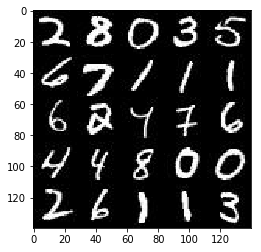

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

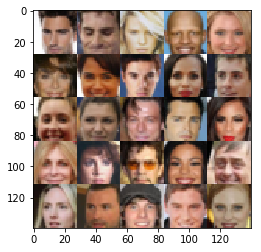

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [99]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
        
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="input_learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [428]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x n_channels
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        lrelu1 = leaky_relu(x1)
        # 14x14x1024
        
        x2 = tf.layers.conv2d(lrelu1, 256, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = leaky_relu(bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(lrelu2, 512, 3, strides=3, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = leaky_relu(bn3)
        # 3x3x512

        # Flatten it
        flat = tf.reshape(lrelu3, (-1, 3*3*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [469]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):

        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = leaky_relu(bn1)
        # 2 x 2 x 512
        
        # setting padding to 'valid' to be able to go from 2x2 to 7x7
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = leaky_relu(bn2)
        # 7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = leaky_relu(bn3)
        # 14 x 14 x 128
        
        
        x4 = tf.layers.conv2d_transpose(lrelu3, 64, 4, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        lrelu4 = leaky_relu(bn4)
        # 28 x 28 x 64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 1, strides=1, padding='same')
        # 28 x 28 x out_channel_dim
        
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [470]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [471]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [472]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [473]:
import numpy as np

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    
    # Building the model
    input_real, input_z, input_learning_rate = model_inputs(28, 28, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()

    losses = []
    steps = 0
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 # to normalize values between -1 and 1
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_learning_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8407... Generator Loss: 0.2167
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 2.2882... Generator Loss: 6.9602
Epoch 1/2... Discriminator Loss: 0.3199... Generator Loss: 2.6366
Epoch 1/2... Discriminator Loss: 2.9280... Generator Loss: 1.0225
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 2.3302
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 1.7945
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 1.4877
Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.7548... Generator Loss: 3.4597


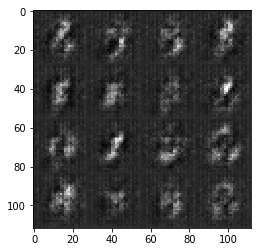

Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 1.9550
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 1.3378
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 2.1689
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 1.9244
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 1.6595
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 1.5148
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 1.7193
Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 1.9523
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.1007


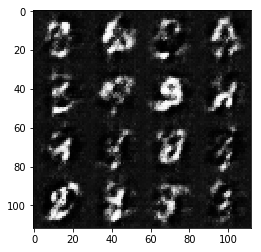

Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 1.8277
Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 1.5793
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.3548
Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 1.9306
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 2.0815
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 1.9266
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 1.7471
Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 1.7515
Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 1.7125
Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 1.8474


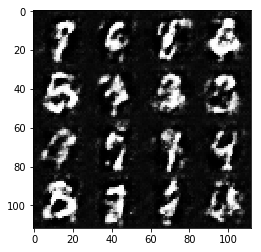

Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.7730
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 1.1241
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.4739
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 2.2647
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 1.8001
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.4047
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 1.5130


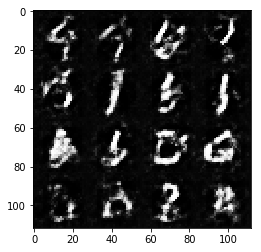

Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 1.8106
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.4861
Epoch 1/2... Discriminator Loss: 0.9247... Generator Loss: 1.2222
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 1.6265
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.3131
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.2880
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.4651
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 2.1531


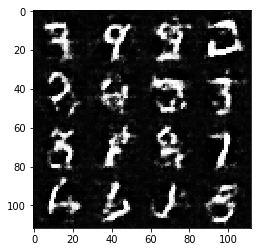

Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.5263
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 2.0772
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 1.6595
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 1.5408
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.3639
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 1.0335
Epoch 1/2... Discriminator Loss: 2.8252... Generator Loss: 2.3749
Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 0.9897


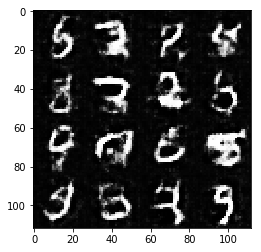

Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.3343
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.2187
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 1.7112
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.9869
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 1.6040
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 1.4773


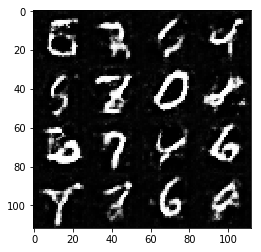

Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 0.7722
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 0.9879... Generator Loss: 1.6827
Epoch 1/2... Discriminator Loss: 2.3317... Generator Loss: 2.9982
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.1610
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 1.9459


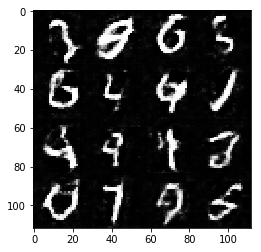

Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 3.4244... Generator Loss: 0.0471
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.8881... Generator Loss: 0.1898
Epoch 1/2... Discriminator Loss: 0.9705... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 0.8975


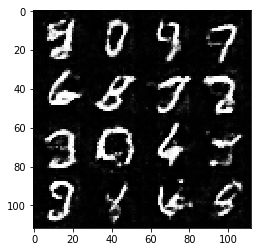

Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 2.6776... Generator Loss: 0.0954
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 1.6173... Generator Loss: 2.6075
Epoch 2/2... Discriminator Loss: 1.0171... Generator Loss: 0.6039
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 1.7919


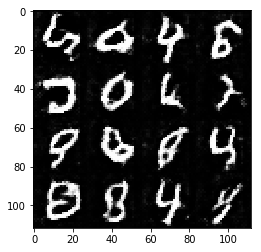

Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.2752
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.5044
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.3941
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 1.2270
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 1.5490


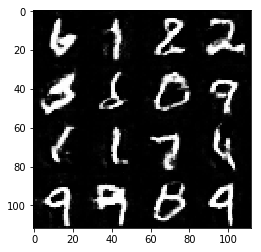

Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.5123
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 0.5025
Epoch 2/2... Discriminator Loss: 1.7316... Generator Loss: 0.2347
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.5019
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 2.9331... Generator Loss: 0.0739
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.4407
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.3618


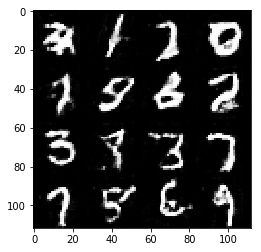

Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.3787
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 2.1535... Generator Loss: 0.1464
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.4569
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.4687


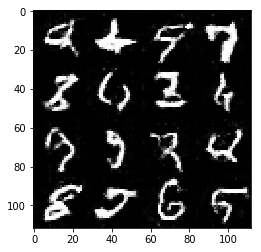

Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 0.7340... Generator Loss: 1.6346
Epoch 2/2... Discriminator Loss: 0.7706... Generator Loss: 1.8349
Epoch 2/2... Discriminator Loss: 0.8111... Generator Loss: 1.3654
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.4753
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.4835
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.5008


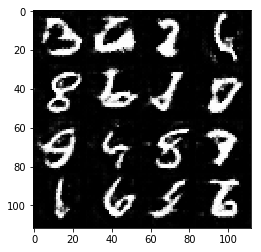

Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 2.0598
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 1.4042
Epoch 2/2... Discriminator Loss: 0.6918... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.7026
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.0930
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.4068
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 1.6213
Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.0784


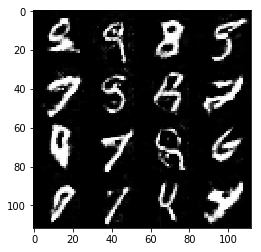

Epoch 2/2... Discriminator Loss: 1.9177... Generator Loss: 0.1850
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 0.6239... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 0.9195... Generator Loss: 0.6416
Epoch 2/2... Discriminator Loss: 2.5413... Generator Loss: 0.0917


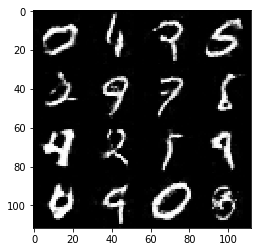

Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.4750
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.6273
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 0.4973
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.3256
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.5248
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.4302
Epoch 2/2... Discriminator Loss: 1.9201... Generator Loss: 0.2177
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.3455


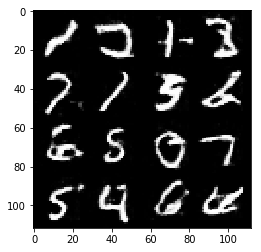

Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.3195
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 0.4903
Epoch 2/2... Discriminator Loss: 0.6929... Generator Loss: 1.7465
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.3583
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.0496
Epoch 2/2... Discriminator Loss: 1.6965... Generator Loss: 2.6762
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 0.9874
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 1.1313


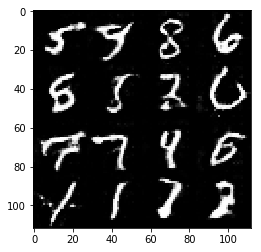

Epoch 2/2... Discriminator Loss: 0.9702... Generator Loss: 0.9743
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 1.5887... Generator Loss: 2.3641
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.3373
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 1.4859
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 0.7846


In [474]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.15


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 12.9726
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 12.0114
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.2700
Epoch 1/1... Discriminator Loss: 2.1828... Generator Loss: 0.1307
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 10.2811
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 15.6309
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 13.3386
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 2.4208
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 3.5916


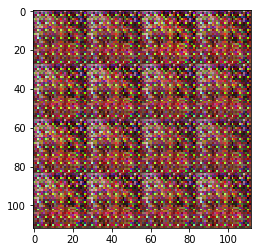

Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 3.7975
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 4.6473
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 4.6847
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 4.3547
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 4.8361
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 4.7466
Epoch 1/1... Discriminator Loss: 0.0317... Generator Loss: 4.2749
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 4.6494
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 7.9194
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 1.5212


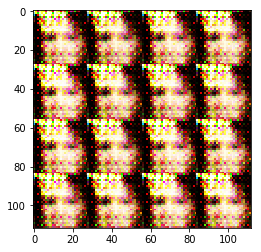

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 0.0594... Generator Loss: 13.7252
Epoch 1/1... Discriminator Loss: 2.5762... Generator Loss: 0.1161
Epoch 1/1... Discriminator Loss: 0.2584... Generator Loss: 3.3416
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 4.8778
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 1.4702
Epoch 1/1... Discriminator Loss: 0.2612... Generator Loss: 2.3415
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 5.3565


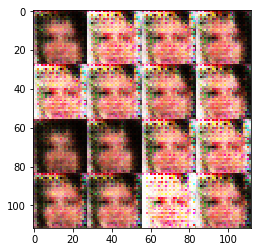

Epoch 1/1... Discriminator Loss: 1.7227... Generator Loss: 5.1585
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 1.8950
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 3.1672
Epoch 1/1... Discriminator Loss: 2.4545... Generator Loss: 5.9696


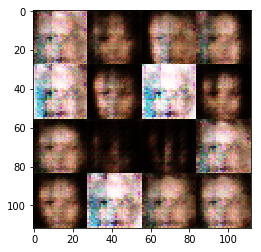

Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 3.0398
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.8634
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 2.6124
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 1.7591
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.7294... Generator Loss: 0.3536


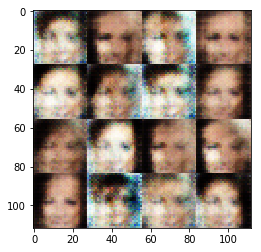

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 4.0462
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 2.8108
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.8474... Generator Loss: 3.3149
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.6195
Epoch 1/1... Discriminator Loss: 1.8630... Generator Loss: 0.2852


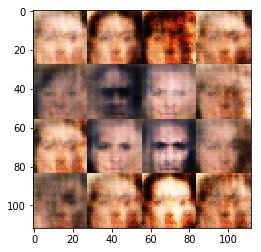

Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 2.6588
Epoch 1/1... Discriminator Loss: 1.7077... Generator Loss: 0.3414


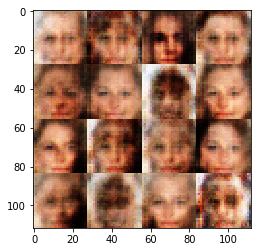

Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 2.0648
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.9776
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 2.1103... Generator Loss: 3.4190
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 2.1737
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 1.1017


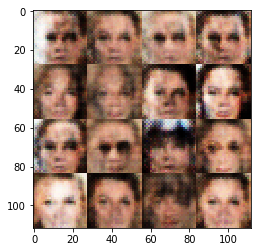

Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 2.6352
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 2.1049
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.9097


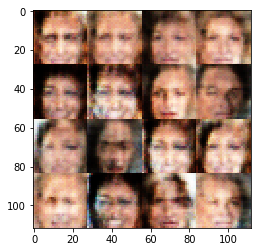

Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 2.6102
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.3133
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 1.9353
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.7461... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 1.8748


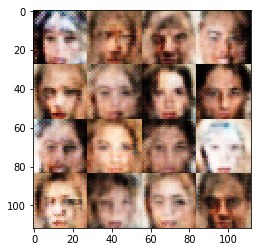

Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.9740
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.7342
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 2.5316
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 2.1405


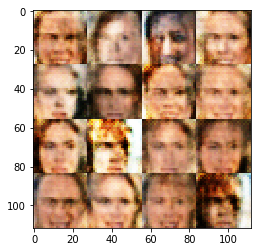

Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 2.9345
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.2775
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 2.8061
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.7452
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 2.5663... Generator Loss: 2.5896


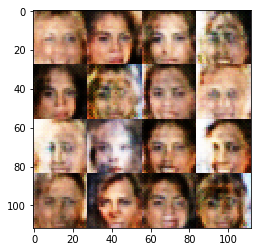

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 2.5067
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.1970
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 2.3261
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.7412
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.3056


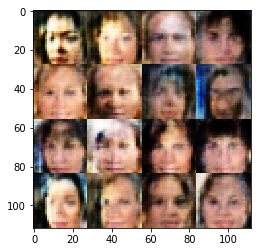

Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.1361


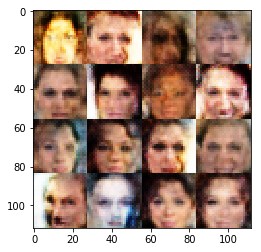

Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.4138
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.7473


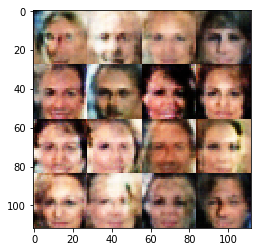

Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 2.0897
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.3018
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.3611
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 0.2907


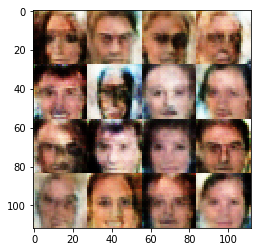

Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.3659
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 2.2174
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.7876


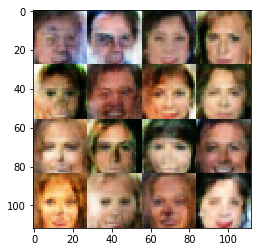

Epoch 1/1... Discriminator Loss: 2.2000... Generator Loss: 2.6231
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.4283
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.8820
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.5657


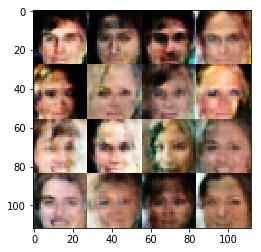

Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.7483
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.9221
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.5510


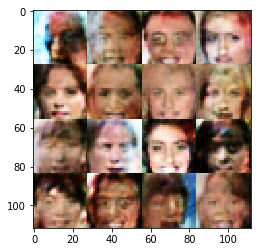

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 2.2227
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.9723
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 2.2499
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.6198


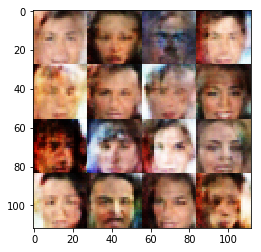

Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 2.3309
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 2.0832
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 2.6644
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.1264


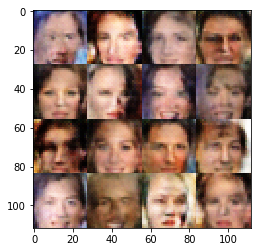

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 2.2073
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 2.4878
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 2.9922
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.3467


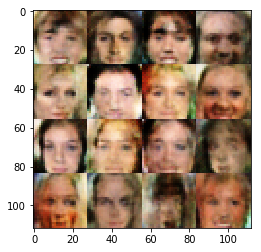

Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 1.5621
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 2.1845
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.5545
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 2.0830


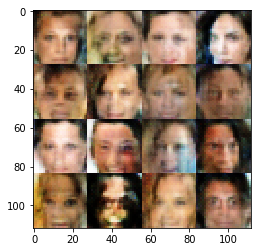

Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.3428
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 1.8411
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.9940
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.1584
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 1.8843
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.6429


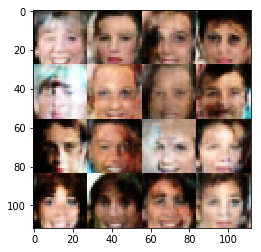

Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 2.2990... Generator Loss: 0.1297
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.8835
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.9542
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 2.5186
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.9984... Generator Loss: 0.2254
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.5223


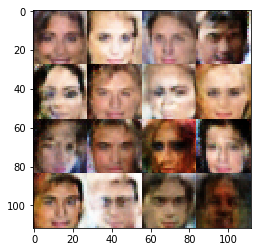

Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 1.6061
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 2.0058
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 2.0947
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 2.3431
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.4510


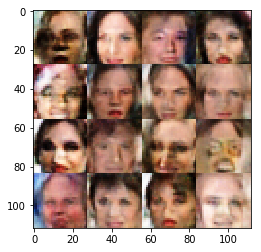

Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 2.7637
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 4.2258
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 3.5243
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 2.8840
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.7405
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 0.8184


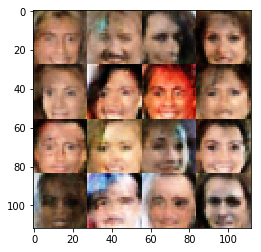

Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 2.4170
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 2.7804
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.8974
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 2.1411
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.6946


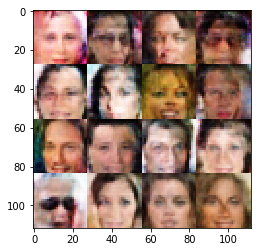

Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 1.7864
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 2.4435
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.7937
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 2.7880
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.5364


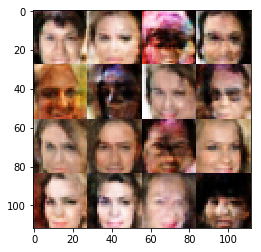

Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 2.4509
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 3.8003
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 2.1340
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 3.3708
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.4575


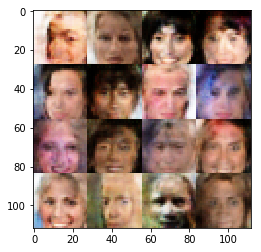

Epoch 1/1... Discriminator Loss: 1.8856... Generator Loss: 0.2004
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 2.4669
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.2806
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.9070
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 2.0564
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 2.2963


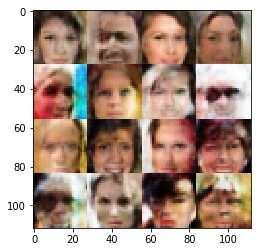

Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.9349
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.3708
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 0.9718


In [476]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.